# **Modeling and Evaluation (Regression) Notebook**

## Objectives
- Fit and evaluate a regression model to predict the Sales Price for a house in Ames, Iowa

## Inputs
- outputs/data_collected/house_oricing_data.csv
- Instructions on which variables to use for data cleaning and feature engineering. They are found in notebook 01 - 03.

## Outputs
- Train set
- Test set
- Data cleaning and Feature Engineering pipeline
- Modeling pipeline


---

## Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/ci-c5-housing-market-prices/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/ci-c5-housing-market-prices'

---

## Step 1: Load data

In [52]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/data_collected/house_pricing_data.csv")  
  )

print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


In [19]:
# Count missing values per column
missing_count_per_column = df.isnull().sum()

# Filter and sort columns with missing values
missing_columns = missing_count_per_column[missing_count_per_column > 0].sort_values(ascending=False)

print("\nColumns with Missing Values and Their Counts:")
print(missing_columns)


Columns with Missing Values and Their Counts:
EnclosedPorch    1324
WoodDeckSF       1305
LotFrontage       259
GarageFinish      235
BsmtFinType1      145
BedroomAbvGr       99
2ndFlrSF           86
GarageYrBlt        81
BsmtExposure       38
MasVnrArea          8
dtype: int64


---

## Step 2: ML Pipeline with all relevant data

ML pipeline for Data Cleaning and Feature Engineering

In [24]:
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection # Import SmartCorrelationSelection
from feature_engine.encoding import OrdinalEncoder # Import OrdinalEncoder
from feature_engine.transformation import LogTransformer  # Import LogTransformer
from feature_engine.imputation import MeanMedianImputer # For Imputation

def drop_unwanted_columns(X):
    return X.drop(columns=[
        'LotFrontage', 'GarageFinish', '2ndFlrSF', 'GarageYrBlt',
        'EnclosedPorch', 'WoodDeckSF', 'BsmtFinType1', 'LotArea',
        'BsmtUnfSF', 'BedroomAbvGr', 'BsmtExposure', 'OverallCond'
    ])


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        # Drop unwanted columns
        ("DropUnwantedFeatures", FunctionTransformer(drop_unwanted_columns, validate=False)),

        # Impute MasVnrArea using mean
        ("ImputeMasVnrArea", MeanMedianImputer(imputation_method='mean', variables=['MasVnrArea'])),

        # Encoding categorical variables using OrdinalEncoder
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual'])),

         # Feature selection based on correlation using SmartCorrelatedSelection
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=['TotalBsmtSF', '1stFlrSF', 'KitchenQual', 'YearRemodAdd', 'GarageArea'],
         method="spearman", threshold=0.6, selection_method="variance")),

        # Apply log10 transformation to selected numeric features
        ("LogTransformation", LogTransformer(variables=['GrLivArea', 'SalePrice'], base='10'))

    ])

    return pipeline_base


# Run the pipeline
PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('DropUnwantedFeatures',
                 FunctionTransformer(func=<function drop_unwanted_columns at 0x756518b0b060>)),
                ('ImputeMasVnrArea',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['MasVnrArea'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['TotalBsmtSF', '1stFlrSF',
                                                     'KitchenQual',
                                                     'YearRemodAdd',
                                                     'GarageArea'])),
                ('LogTransformation',
                 LogTransformer(base='10',
                                variables=['GrLivArea', 'SalePrice']))])

In [ ]:
# 1. Get the pipeline
pipeline = PipelineDataCleaningAndFeatureEngineering()

# 2. Fit and transform  DataFrame
df_transformed = pipeline.fit_transform(df)

# 3. View the result
print(df_transformed.head())

   BsmtFinSF1  GarageArea  GrLivArea  KitchenQual  MasVnrArea  OpenPorchSF  \
0         706         548   3.232996            0       196.0           61   
1         978         460   3.101059            1         0.0            0   
2         486         608   3.251881            0       162.0           42   
3         216         642   3.234770            0         0.0           35   
4         655         836   3.342028            0       350.0           84   

   OverallQual  TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0            7          856       2003          2003   5.319106  
1            6         1262       1976          1976   5.258877  
2            7          920       2001          2002   5.349278  
3            7          756       1915          1970   5.146128  
4            8         1145       2000          2000   5.397940  


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/transformation/log.py:169: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.23299611 3.10105935 3.25188145 ... 3.36921586 3.03261876 3.09898964]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.log10(X.loc[:, self.variables_])
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/transformation/log.py:169: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5.31910606 5.25887663 5.34927753 ... 5.42569721 5.15267048 5.16879202]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.log10(X.loc[:, self.variables_])


ML Pipeline for Modelling, import libaries (in progress)

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # a Random Forest model is used here
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


# Feat Scaling
# from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import AdaBoostClassifier
#from xgboost import XGBClassifier


def PipelineClassf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

### Hyperparameter Optimisation

Use GridSearch algorithm to find the best combination of hyperparameters for the model.

In [ ]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Check Target Imbalance

Ensure that the data has no catergorical or non-numeric values. Therefore, the data cleaning pipeline is used before.

In [ ]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Check Target distribution of Train Set --> target shouldn't be imbalance because of the numeric tranformation of sales price (log10)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot target distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=40, kde=True, color='skyblue')
plt.axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: ${y_train.mean():,.0f}')
plt.axvline(y_train.median(), color='green', linestyle='--', label=f'Median: ${y_train.median():,.0f}')
plt.title("Distribution of Sale Prices in Training Set")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Split Train and Test Set

X_train and y_train will be used to train the model.

X_test and y_test will be used to evaluate the model.

In [35]:
# Define features and target variable
X = df_transformed.drop(columns=['SalePrice'])  # All columns except 'SalePrice' are features
y = df_transformed['SalePrice']  # 'SalePrice' is the target variable

# Split the data into training and test sets (80% train, 20% test is common)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scale the data

Using a model that is sensitive to the scale of data (like linear models or k-nearest neighbors) a scaler function is necessary. For tree-based models like RandomForest, scaling is not strictly necessary, but it’s good practice for certain models

In [36]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data, and transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Choose and train a Model

In [37]:
# Initialize the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

### Make Predictions and Evaluate the Model

In [38]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model using different metrics
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)    # Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 0.04634003198324543
Mean Squared Error (MSE): 0.004879238280340573
Root Mean Squared Error (RMSE): 0.06985154458092228


---

## Step 3: Refine pipeline with best features

Only apply the six relevant features (= variables) for a new pipeline.

---

##  Step 4: Push files to Repo

The following files will be generated:
- Train Set
- Test Set
- Data cleaning and Feature Engineering pipeline
- Modeling pipeline

In [39]:
pipeline_dc_fe = PipelineDataCleaningAndFeatureEngineering()

In [41]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipelines/predict_SalePrice/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

# Save trained model
joblib.dump(value=pipeline_dc_fe ,
            filename=f"{file_path}/pipeline_data_cleaning_feat_eng.pkl")
joblib.dump(value=model ,
            filename=f"{file_path}/model.pkl")

['outputs/ml_pipelines/predict_SalePrice/v1/model.pkl']

## Train Set

In [42]:
print(X_train.shape)
X_train.head()

(1168, 10)


,BsmtFinSF1,GarageArea,GrLivArea,KitchenQual,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
254,922,294,3.118595,1,0.0,0,5,1314,1957,1957
1066,0,380,3.196176,1,0.0,40,6,799,1993,1994
638,0,0,2.900913,1,0.0,0,5,796,1910,1950
799,569,240,3.247482,0,252.0,0,5,731,1937,1950
380,218,308,3.228144,0,0.0,0,5,1026,1924,1950


In [43]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [44]:
y_train

254     5.161368
1066    5.250420
638     4.929419
799     5.243038
380     5.103804
          ...   
1095    5.246577
1130    5.130334
1294    5.060698
860     5.278639
1126    5.240549
Name: SalePrice, Length: 1168, dtype: float64

In [45]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

In [46]:
print(X_test.shape)
X_test.head()

(292, 10)


,BsmtFinSF1,GarageArea,GrLivArea,KitchenQual,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
892,663,264,3.028571,1,0.0,0,6,1059,1963,2003
1105,1032,712,3.418633,0,362.0,32,8,1463,1994,1995
413,0,360,3.011993,1,0.0,0,5,1008,1927,1950
522,399,420,3.221153,1,0.0,24,6,1004,1947,1950
1036,1022,912,3.209515,2,70.0,0,9,1620,2007,2008


In [47]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [48]:
y_test

892     5.188928
1105    5.511883
413     5.060698
522     5.201397
1036    5.498999
          ...   
479     4.951682
1361    5.414973
802     5.276462
651     5.033424
722     5.095169
Name: SalePrice, Length: 292, dtype: float64

In [49]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Combine Data Engineering and model pipeline (in progress)

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import joblib
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("outputs/data_collected/house_pricing_data.csv")

# Define features and target
X = df.drop(columns=['SalePrice'])  # Assuming you already have SalePrice
y = df['SalePrice']

# Data cleaning: Drop specified columns and fill missing values for relevant columns
X = X.drop(columns=['BsmtFinType1', 'LotArea', 'BsmtFinType1', 'BsmtUnfSF', 'BedroomAbvGr', 'BsmtExposure', 'OverallCond', 'GarageYrBlt', 'LotFrontage', 'EnclosedPorch', 'WoodDeckSF', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', '2ndFlrSF', 'KitchenQual', 'GarageFinish'])

# Data cleaning: Fill missing values in 'MasVnrArea' column with the mean
X['MasVnrArea'] = X['MasVnrArea'].fillna(X['MasVnrArea'].mean())

# Data cleaning: Ensure the columns to which you will apply the log transformation are float64
X['GrLivArea'] = X['GrLivArea'].astype('float64')

# Define preprocessing steps
preprocessing = Pipeline([
        # Apply log10 transformation to selected numeric features
        ("LogTransformation", LogTransformer(variables=['GrLivArea'], base='10'))
    ])

# Combine preprocessing with model
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('LogTransformation',
                                  LogTransformer(base='10',
                                                 variables=['GrLivArea']))])),
                ('model', RandomForestRegressor(random_state=42))])

---

## Model evaluation

In [56]:
y_pred = full_pipeline.predict(X_test)

# Evaluate the model using different metrics
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)    # Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 20923.894706457922
Mean Squared Error (MSE): 1010628501.9416814
Root Mean Squared Error (RMSE): 31790.383796703074


By using RandomForestRegressor model, the performance of the model can often be improved by tuning its hyperparameters. A hyperparameter optimization techniques is used such as GridSearchCV (or RandomizedSearchCV) to find the best parameters for your model.

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None]
}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'model__max_depth': None, 'model__n_estimators': 100}


Save pipeline

In [59]:
# Create folder if needed
model_path = "outputs/ml_pipelines/predict_SalePrice/v1"
os.makedirs(model_path, exist_ok=True)

# Save pipeline
joblib.dump(full_pipeline, f"{model_path}/full_pipeline.pkl")

['outputs/ml_pipelines/predict_SalePrice/v1/full_pipeline.pkl']

---

## Visualisatons

### Residuals Plot (for Regression Models)

Purpose: To check if residuals (errors) are randomly distributed. This helps in validating assumptions of homoscedasticity in regression models.

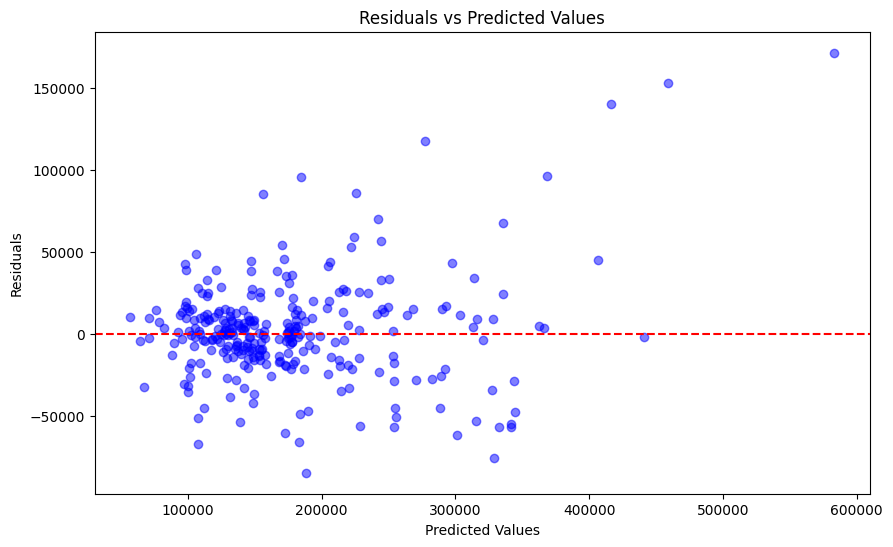

In [ ]:
import matplotlib.pyplot as plt

# Assuming there is a regression model and y_pred provided
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()